In [72]:
import pandas as pd
df = pd.read_excel("C:\\Users\\sadin\\OneDrive\\Desktop\\Sadini\\hotel_booking_cancellation\\hotel_bookings_cleaned.xlsx")

### model building

In [73]:
# encoding

In [74]:
# Convert 'arrival_date_month' to numerical values
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df['arrival_date_month'] = df['arrival_date_month'].apply(lambda x: months.index(x) + 1)

# One-hot encode the specified columns
one_hot_cols = ['hotel', 'meal', 'market_segment', 'distribution_channel', 'deposit_type', 'customer_type','continent']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118987 entries, 0 to 118986
Data columns (total 46 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     118987 non-null  int64  
 1   lead_time                       118987 non-null  int64  
 2   arrival_date_month              118987 non-null  int64  
 3   arrival_date_week_number        118987 non-null  int64  
 4   arrival_date_day_of_month       118987 non-null  int64  
 5   stays_in_weekend_nights         118987 non-null  int64  
 6   stays_in_week_nights            118987 non-null  int64  
 7   adults                          118987 non-null  int64  
 8   children                        118987 non-null  int64  
 9   babies                          118987 non-null  int64  
 10  is_repeated_guest               118987 non-null  int64  
 11  previous_cancellations          118987 non-null  int64  
 12  previous_booking

In [76]:
df.isnull().sum() #checking nulls

is_canceled                       0
lead_time                         0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
booking_changes                   0
days_in_waiting_list              0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
room_mismatch                     0
hotel_Resort Hotel                0
meal_FB                           0
meal_HB                           0
meal_SC                           0
meal_Undefined                    0
market_segment_Complementary      0
market_segment_Corporate          0
market_segment_Direct             0
market_segment_Groups       

In [77]:
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']

# XGBOOST

In [78]:
import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay

In [79]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
# Define the model
xgb_base = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [250, 350],
    'learning_rate': [0.01, 0.1],
    'max_depth': [7, 8],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.8, 0.9],
    'scale_pos_weight': [(y_train == 0).sum() / (y_train == 1).sum()]
}

# Performing GridSearch for XGBoost
grid_search = GridSearchCV(estimator=xgb_base, param_grid=param_grid_xgb, 
                          scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model and hyperparameters of XGBoost
best_xgb = grid_search.best_estimator_
best_xgb_hyperparams = grid_search.best_params_

# best hyperparameters for XGBoost
print("XGBoost Optimal Hyperparameters:\n", best_xgb_hyperparams)

# Predictions from XGBoost
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)

# accuracy of XGBoost
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Classification Reports of XGBoost
print("\nClassification Report (Train Data):\n", classification_report(y_train, y_train_pred))
print("\nClassification Report (Test Data):\n", classification_report(y_test, y_test_pred))

Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Users\sadin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Optimal Hyperparameters:
 {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 350, 'scale_pos_weight': 1.6971834976765272, 'subsample': 0.8}
Train Accuracy: 0.9053
Test Accuracy: 0.8535

Classification Report (Train Data):
               precision    recall  f1-score   support

           0       0.94      0.91      0.92     59897
           1       0.86      0.89      0.87     35292

    accuracy                           0.91     95189
   macro avg       0.90      0.90      0.90     95189
weighted avg       0.91      0.91      0.91     95189


Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.89      0.87      0.88     14975
           1       0.79      0.82      0.81      8823

    accuracy                           0.85     23798
   macro avg       0.84      0.85      0.84     23798
weighted avg       0.85      0.85      0.85     23798



### confusion matrix, ROC curve for test data


Confusion Matrix (Test Data):


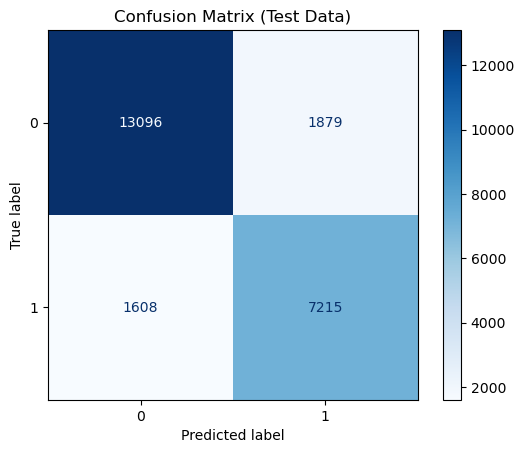


ROC Curve (Test Data):


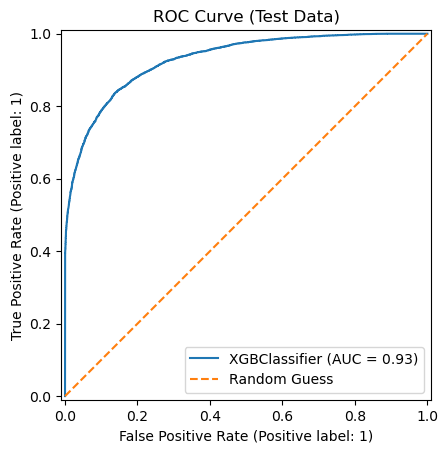


ROC AUC Score (Test Data): 0.9296


In [81]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Confusion Matrix for Test Data
print("\nConfusion Matrix (Test Data):")
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgb.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Test Data)")
plt.show()

# ROC Curve for Test Data
print("\nROC Curve (Test Data):")
RocCurveDisplay.from_estimator(best_xgb, X_test, y_test)
plt.title("ROC Curve (Test Data)")
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')  # Add diagonal line
plt.legend()
plt.show()

# ROC AUC Score
y_test_proba = best_xgb.predict_proba(X_test)[:, 1]  # Probabilities for class 1
roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"\nROC AUC Score (Test Data): {roc_auc:.4f}")

<Figure size 1000x800 with 0 Axes>

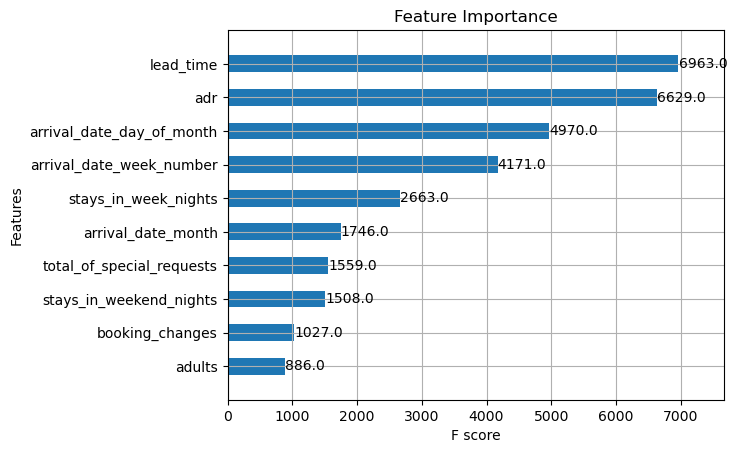

In [82]:
import matplotlib.pyplot as plt

# Plotting feature importance for the best XGBoost model
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_xgb, importance_type='weight', max_num_features=10, height=0.5)
plt.title('Feature Importance')
plt.show()

# Random Forest

In [83]:
# manual hyperparameter tuning is done since GridSearchCV did not give good recall for Random Forest

#defining the model
rf_tuned = RandomForestClassifier(
    n_estimators=250,        # More trees for stability  
    criterion='gini',        # 'gini' often works better for imbalanced data  
    max_depth=24,            # Slightly shallower to reduce overfitting  
    min_samples_split=4,     # Helps generalization  
    min_samples_leaf=2,      # Avoids very small leaves  
    class_weight={0: 1, 1: 2},  # Adjust class weight to balance recall & precision  
    random_state=0,  
    n_jobs=-1  
)

# Train the model
rf_tuned.fit(X_train, y_train)

# Predictions on train and test sets
y_train_pred = rf_tuned.predict(X_train)
y_test_pred = rf_tuned.predict(X_test)

# Evaluate performance
print("==== Train Data Evaluation ====")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Train Classification Report:\n", classification_report(y_train, y_train_pred))

print("\n==== Test Data Evaluation ====")
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

==== Train Data Evaluation ====
Train Accuracy: 0.9044637510636733
Train Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92     59897
           1       0.85      0.90      0.87     35292

    accuracy                           0.90     95189
   macro avg       0.89      0.90      0.90     95189
weighted avg       0.91      0.90      0.90     95189


==== Test Data Evaluation ====
Test Accuracy: 0.8559963022102698
Test Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88     14975
           1       0.80      0.82      0.81      8823

    accuracy                           0.86     23798
   macro avg       0.84      0.85      0.85     23798
weighted avg       0.86      0.86      0.86     23798



Feature Importances
                           Feature  Importance
34         deposit_type_Non Refund    0.141594
0                        lead_time    0.141472
16       total_of_special_requests    0.082754
17                   room_mismatch    0.069485
14                             adr    0.066364
10          previous_cancellations    0.046741
15     required_car_parking_spaces    0.043837
2         arrival_date_week_number    0.041841
3        arrival_date_day_of_month    0.040494
12                 booking_changes    0.031685
5             stays_in_week_nights    0.028578
28        market_segment_Online TA    0.027154
1               arrival_date_month    0.026858
37         customer_type_Transient    0.023918
38   customer_type_Transient-Party    0.020655
27    market_segment_Offline TA/TO    0.020055
26           market_segment_Groups    0.019612
4          stays_in_weekend_nights    0.017176
32      distribution_channel_TA/TO    0.015099
18              hotel_Resort Hotel    0.

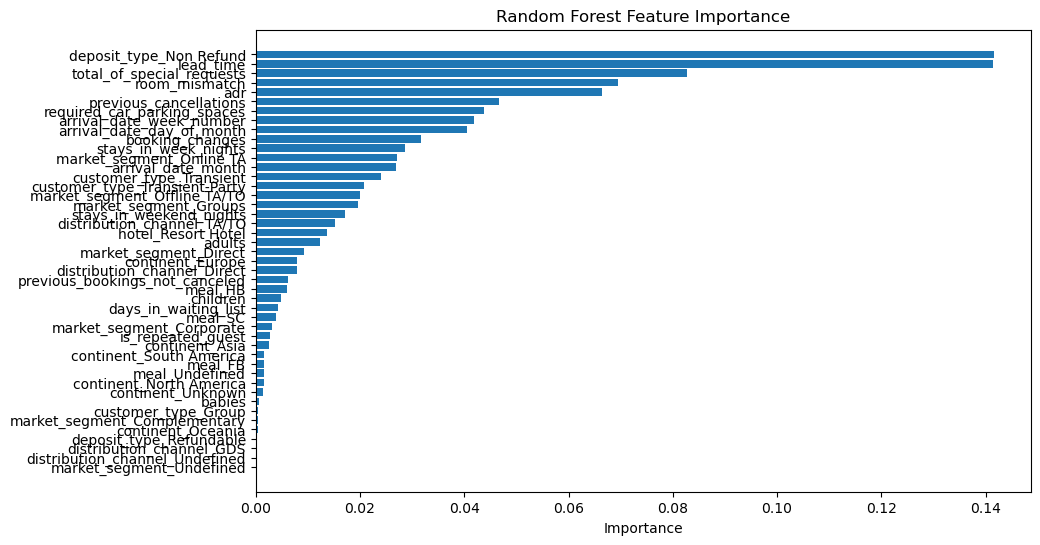

In [84]:
feature_names = X_train.columns  

# Get feature importances
importances = rf_tuned.feature_importances_

# Create a DataFrame for easy viewing
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances")
print(feature_importance_df)

# Optional: Visualize the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()



Confusion Matrix (Test Data):


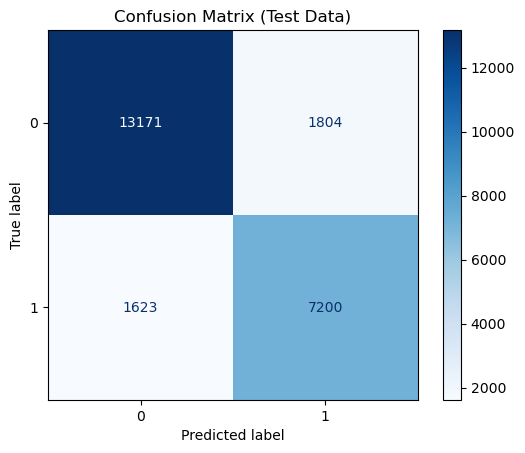


ROC Curve (Test Data):


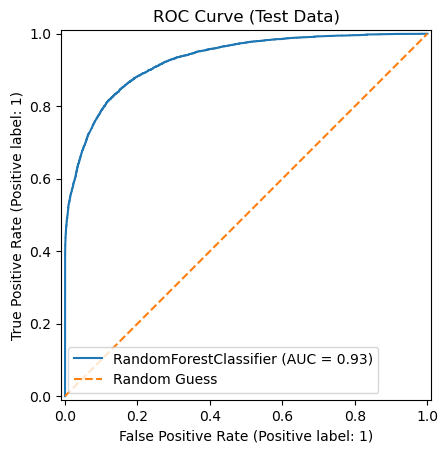


ROC AUC Score (Test Data): 0.9287


In [85]:
import numpy as np
from sklearn.metrics import confusion_matrix

print("\nConfusion Matrix (Test Data):")
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Test Data)")
plt.show()

# ROC Curve for Test Data
print("\nROC Curve (Test Data):")
RocCurveDisplay.from_estimator(rf_tuned, X_test, y_test)
plt.title("ROC Curve (Test Data)")
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')  # Add diagonal line
plt.legend()
plt.show()

# ROC AUC Score
y_test_proba = rf_tuned.predict_proba(X_test)[:, 1]  # Probabilities for class 1
roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"\nROC AUC Score (Test Data): {roc_auc:.4f}")